In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.utils.metaestimators import available_if
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, BisectingKMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import kstest

from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score

sns.set(rc={'figure.figsize':(16,10)})
pd.set_option("display.max_columns", None)

In [16]:
meta = pd.read_csv('songs_metadata.csv', index_col=0)
df   = pd.read_csv('songs_features.csv', index_col=0)
artist = pd.read_csv('artist_features.csv', index_col=0)

In [17]:
artist = artist.rename(columns={
    'genres':'artist_genres',
    'popularity':'artist_popularity',
    'followers':'artist_followers'
    })

meta = meta.rename(columns={
    'popularity':'song_popularity'
    })

In [18]:
df = df.merge(
        meta, 
        left_on='id',
        right_on='song_id',
        how='left')

df = df.merge(
        artist, 
        on='artist_uri',
        how='left',
        suffixes=['_song','_artist'])

In [19]:
df['artist_genres'] = df['artist_genres'].apply(lambda x: x.\
    replace("['","").replace("']","").replace("'","").split(','))

In [20]:
df['release_year'] = df['realese_date'].apply(lambda x: int(x.split('-')[0]))
df = df.drop(columns=['realese_date'])
data = df.drop_duplicates(subset='song_name')

In [21]:
data = data[['song_name', 'artist', 'album', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'song_popularity',
       'artist_genres', 'artist_popularity', 'artist_followers',
       'release_year']]

In [22]:
data.head()

df = data.copy()
df.head(3)

,song_name,artist,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_genres,artist_popularity,artist_followers,release_year
0,Matador,Onda Sabanera,Lluvia de Exitos/Cumbia Hasta las Manos,0.851,0.843,11,-3.634,0,0.0447,0.2550,0.000667,0.163,0.964,96.034,197120,44,[cumbia villera],45,68434,2007
2,Matador - Remasterizado 2008,Los Fabulosos Cadillacs,Vasos Vacíos,0.543,0.962,4,-5.337,0,0.1060,0.0274,0.027000,0.090,0.639,193.660,275893,60,"[argentine rock, latin alternative, latin ro...",67,2633939,1993
3,El Campanero,Onda Sabanera,Lluvia de Exitos/Cumbia Hasta las Manos,0.595,0.749,7,-6.627,1,0.0702,0.0216,0.000000,0.244,0.888,192.579,283333,46,[cumbia villera],45,68434,2007


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291 entries, 0 to 551
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   song_name          291 non-null    object 
 1   artist             291 non-null    object 
 2   album              291 non-null    object 
 3   danceability       291 non-null    float64
 4   energy             291 non-null    float64
 5   key                291 non-null    int64  
 6   loudness           291 non-null    float64
 7   mode               291 non-null    int64  
 8   speechiness        291 non-null    float64
 9   acousticness       291 non-null    float64
 10  instrumentalness   291 non-null    float64
 11  liveness           291 non-null    float64
 12  valence            291 non-null    float64
 13  tempo              291 non-null    float64
 14  duration_ms        291 non-null    int64  
 15  song_popularity    291 non-null    int64  
 16  artist_genres      291 non

In [24]:
scaler = StandardScaler()
df_numeric = scaler.fit_transform(df.select_dtypes(include=np.number).drop("key", axis = 1))
df_numeric_columns = df.drop("key", axis = 1).select_dtypes(include=np.number).columns.tolist()
df_numeric = pd.DataFrame(df_numeric, columns= df_numeric_columns)

df_numeric.head()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_popularity,artist_followers,release_year
0,1.617837,0.814217,1.291216,-0.976228,-0.386966,-0.208198,-0.342132,-0.259018,1.462619,-0.858412,-0.421593,-0.003003,-0.511718,-0.385004,0.335313
1,-0.204204,1.357107,0.788670,-0.976228,0.790627,-0.935598,-0.220627,-0.621507,0.176210,2.594180,0.695119,0.632586,0.632542,-0.015427,-0.641146
2,0.103413,0.385380,0.407997,1.024351,0.102897,-0.954135,-0.345209,0.143195,1.161798,2.555950,0.800590,0.076445,-0.511718,-0.385004,0.335313
3,0.618081,-0.162072,-0.746118,1.024351,1.213253,0.565223,-0.345079,1.046935,0.401826,-1.469704,-1.005473,-0.042728,-0.199647,-0.370457,0.893290
4,-0.204204,-0.490543,-0.195471,-0.976228,0.498630,0.200884,-0.345161,-0.652791,-0.765838,-1.357348,0.098395,-0.559143,-1.551954,-0.394112,0.265566


# KMEANS

- Inicialmente instanciaremos un modelo KMeans de baseline, para ver si encuentra alguna estructura en los datos.

- Para elegir el numero de clusters, utilizaremos metricas de validacion interna (Silhoutte score, Calinski-Harabasz, Inertia).

- Supuestos de Kmeans: 
    - Misma varianza en todos los clusters.
    - Mismo tamaño en todos los clusters.
    - Clusters con forma esferica (convexa).

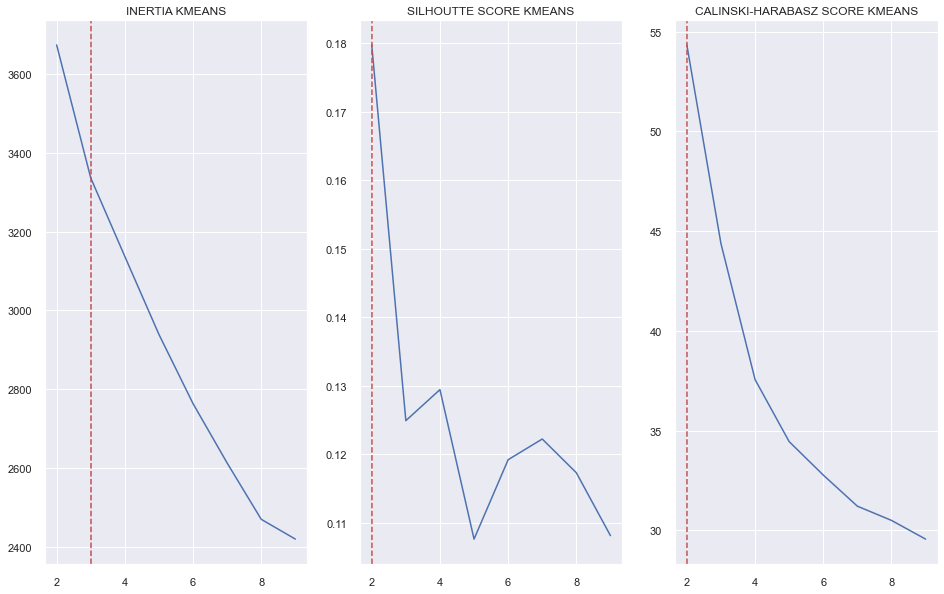

In [25]:
sil_score_kme = []
inertia_score_kme = []
ch_score_kme = []
n_clusters = np.arange(2,10)

for cluster in n_clusters:
    kme=KMeans(n_clusters= cluster)
    inertia_score_kme.append(kme.fit(df_numeric).inertia_)
    sil_score_kme.append(silhouette_score(df_numeric, kme.fit_predict(df_numeric)))
    ch_score_kme.append(calinski_harabasz_score(df_numeric, kme.fit_predict(df_numeric)))


fig1, ax1=plt.subplots(1,3)
sns.lineplot(x = n_clusters, y = inertia_score_kme, ax=ax1[0])
ax1[0].set_title("INERTIA KMEANS")
ax1[0].axvline(x = 3, color = "r", linestyle='--')

sns.lineplot(x = n_clusters, y = sil_score_kme, ax=ax1[1])
ax1[1].set_title("SILHOUTTE SCORE KMEANS")
ax1[1].axvline(x = 2, color = "r", linestyle='--')

sns.lineplot(x = n_clusters, y = ch_score_kme, ax=ax1[2])
ax1[2].set_title("CALINSKI-HARABASZ SCORE KMEANS")
ax1[2].axvline(x = 2, color = "r", linestyle='--');

Observamos que las metricas de validacion interna para KMeans, nos sugieren un numero de clusters entre 2 y 3, hay que tener en consideracion que el maximo valor de Silhoutte score, dio ~0.18, lo cual nos sugiere que no son muy buenos los clusters formados, un valor cercano a 0 indica solapamiento entre los clusters.

# DBSCAN
Debido a que nuestro dataset no tiene demasiados registros (menos de 300 observaciones), optamos por probar con un algoritmo de clustering basado en densidad el cual no asume nada sobre la estructura de los datos (como si lo hacen por ejemplo kmeans y mixtura gausseana).

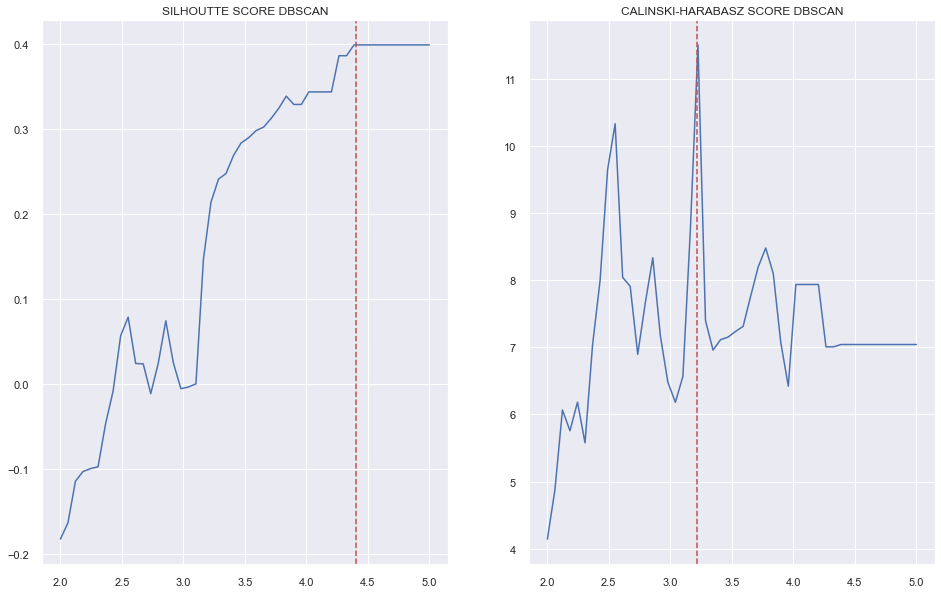

In [26]:
sil_score_dbs = []
ch_score_dbs = []
epsilons = np.linspace(2, 5, 50)

for epsilon in epsilons:
    dbs=DBSCAN(eps=epsilon, min_samples=3)
    sil_score_dbs.append(silhouette_score(df_numeric, dbs.fit_predict(df_numeric)))
    ch_score_dbs.append(calinski_harabasz_score(df_numeric, dbs.fit_predict(df_numeric)))

fig2, ax2=plt.subplots(1,2)

sns.lineplot(x = epsilons, y = sil_score_dbs, ax=ax2[0])
ax2[0].set_title("SILHOUTTE SCORE DBSCAN")
ax2[0].axvline(x = 4.4, color = "r", linestyle='--')

sns.lineplot(x = epsilons, y = ch_score_dbs, ax=ax2[1])
ax2[1].set_title("CALINSKI-HARABASZ SCORE DBSCAN")
ax2[1].axvline(x = 3.22, color = "r", linestyle='--');

Las metricas nos sugieren dos valores de epsilon (4.4 y 3.22), cabe destacar que si bien el silhoutte score aumento respecto al metodo KMeans, sigue siendo pequeno ~0.4, lo cual indica solapamiento entre los clusters.

# SPECTRAL CLUSTERING

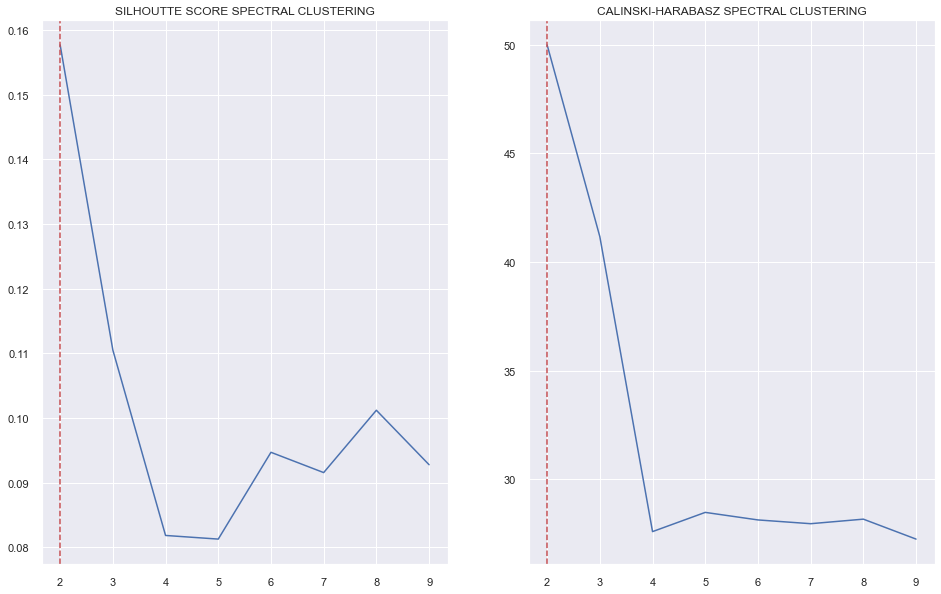

In [27]:
ch_score_sc = []
sil_score_sc = []
clusters = np.arange(2,10)

for cluster in clusters:
    sc = SpectralClustering(n_clusters=cluster, affinity='nearest_neighbors',random_state=1203, assign_labels = "cluster_qr").fit(df_numeric)
    sil_score_sc.append(silhouette_score(df_numeric, sc.fit_predict(df_numeric)))
    ch_score_sc.append(calinski_harabasz_score(df_numeric, sc.fit_predict(df_numeric)))
    
fig3, ax3=plt.subplots(1,2)

sns.lineplot(x = clusters, y = sil_score_sc, ax=ax3[0])
ax3[0].set_title("SILHOUTTE SCORE SPECTRAL CLUSTERING")
ax3[0].axvline(x = 2, color = "r", linestyle='--')

sns.lineplot(x = clusters, y = ch_score_sc, ax=ax3[1])
ax3[1].set_title("CALINSKI-HARABASZ SPECTRAL CLUSTERING")
ax3[1].axvline(x = 2, color = "r", linestyle='--');

Notamos que DBSCAN hizo un mejor trabajo generando los clusters, ya que su silhoutte es mayor que en este caso.

# UMAP


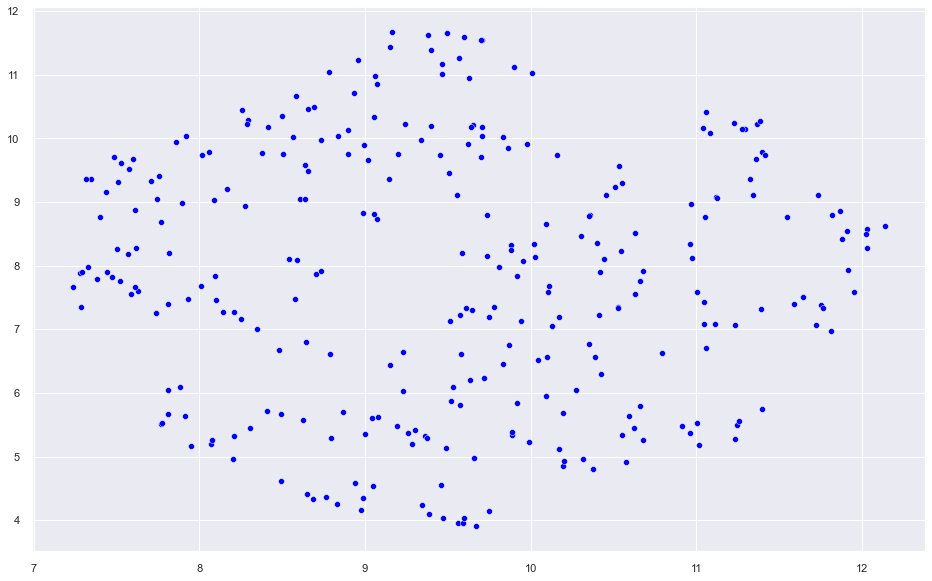

In [28]:
reducer = umap.UMAP(random_state=0)

embedding = reducer.fit_transform(df_numeric)
embedding.shape

sns.scatterplot(x = embedding[:,0], y=embedding[:,1], color="blue");

parecieran formarse 2 , vamos a intentar un metodo jerarquico divisivo, para ver que resultados nos arroja

In [29]:
bkm = BisectingKMeans(n_clusters=2, random_state= 1203)

sil_score_bkm = silhouette_score(embedding, bkm.fit_predict(embedding))
ch_score_bkm = calinski_harabasz_score(embedding, bkm.fit_predict(embedding))

print("Silhoutte score :", sil_score_bkm)
print("calinski-harabasz score :", ch_score_bkm)

Silhoutte score : 0.43019193
calinski-harabasz score : 304.527779162154


Observamos que pudimos mejorar un poco nuestras metricas, con lo que conseguimos nuestro mejor modelo.

In [30]:
df["bkm_labels"]=bkm.fit_predict(embedding)
df_numeric["bkm_labels"] = bkm.fit_predict(embedding)

df.bkm_labels.value_counts()

0    159
1    132
Name: bkm_labels, dtype: int64

In [31]:
df[df.bkm_labels==0].sample(5)

,song_name,artist,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_genres,artist_popularity,artist_followers,release_year,bkm_labels
473,Désolé pour hier soir XXV - Remix 2020,Tryo,Désolé pour hier soir XXV (Remix 2020),0.766,0.818,0,-6.792,0,0.0789,0.1650,0.000000,0.1580,0.689,109.997,205643,48,"[chanson, chanson virale, french pop, frenc...",53,474711,2020,0
422,Walk Of Life - Live Version,Dire Straits,On The Night,0.356,0.979,4,-6.617,1,0.0603,0.0179,0.119000,0.9560,0.712,176.980,306067,50,"[album rock, classic rock, mellow gold, roc...",75,6109261,1993,0
356,"Burning Heart - From ""Rocky IV"" Soundtrack",Survivor,Survivor Greatest Hits,0.652,0.609,9,-9.684,0,0.0280,0.2980,0.000009,0.0573,0.646,98.125,230107,67,"[album rock, hard rock, rock, soft rock]",68,903850,1993,0
408,Dreams (Will Come Alive),2 Brothers On The 4th Floor,Dreams,0.702,0.953,7,-6.347,0,0.0473,0.0113,0.001930,0.2660,0.507,134.027,264000,65,"[bubblegum dance, eurodance, europop, happy...",53,87551,1994,0
434,Let's Twist Again,Chubby Checker,It's Pony Time/Let's Twist Again,0.604,0.709,8,-6.377,1,0.1580,0.0987,0.000000,0.0551,0.907,167.832,137360,68,"[adult standards, brill building pop, bubble...",56,282015,1961,0


In [32]:
df[df.bkm_labels==1].sample(5)

,song_name,artist,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_genres,artist_popularity,artist_followers,release_year,bkm_labels
48,Aquellos Soldaditos De Plomo,Victor Heredia,De Amor y De Sangre,0.292,0.244,9,-13.873,1,0.0417,0.787,0.00000,0.159,0.199,71.502,261800,0,"[argentine rock, cantautor, musica andina ch...",50,142122,1995,1
89,Somebody to Love,Jefferson Airplane,Best Of,0.498,0.647,4,-9.058,1,0.0360,0.322,0.00000,0.361,0.579,130.056,178147,0,"[acid rock, blues rock, classic rock, folk ...",60,1375564,2007,1
69,Alive - Reprise,Hyde,Jekyll & Hyde,0.281,0.646,9,-7.564,0,0.0527,0.813,0.00757,0.516,0.451,44.370,86893,28,[[]],18,121,2005,1
344,A Orillas del Río Dulce,Leandro Lovato,Musiquero,0.756,0.723,9,-6.833,0,0.1260,0.657,0.01240,0.169,0.691,113.513,127427,12,"[folklore argentino, folklore cuyano]",28,8290,2016,1
227,Huellas,Cristina Zivec,Huellas,0.616,0.374,9,-10.727,0,0.4350,0.803,0.00000,0.126,0.541,144.779,182056,0,[[]],0,13,2019,1


In [33]:
df_numeric.select_dtypes(include=np.number).groupby("bkm_labels").agg(["mean","var"])

danceability              energy            loudness            \
                   mean       var      mean       var      mean       var   
bkm_labels                                                                  
0              0.082318  0.888463  0.625162  0.329742  0.483648  0.471757   
1             -0.099155  1.131662 -0.753037  0.777914 -0.582575  1.026488   

                mode           speechiness           acousticness            \
                mean       var        mean       var         mean       var   
bkm_labels                                                                    
0          -0.233874  0.939960    0.011002  0.784389    -0.532214  0.375381   
1           0.281712  0.941327   -0.013252  1.274993     0.641076  1.010715   

           instrumentalness            liveness             valence            \
                       mean       var      mean       var      mean       var   
bkm_labels                                                                      
0                 -0.198540  0.349399  0.164148  1.414770  0.227243  0.915792   
1                  0.239151  1.694489 -0.197723  0.442914 -0.273725  0.978657   

              tempo           duration_ms           song_popularity            \
               mean       var        mean       var            mean       var   
bkm_labels                                                                      
0           0.34017  0.892572    0.230127  1.191506        0.364009  0.726837   
1          -0.40975  0.835211   -0.277199  0.642587       -0.438466  0.990187   

           artist_popularity           artist_followers            \
                        mean       var             mean       var   
bkm_labels                                                          
0                   0.391456  0.586912         0.226598  1.659664   
1                  -0.471527  1.103469        -0.272947  0.082252   

           release_year            
                   mean       var  
bkm_labels                         
0             -0.059482  0.946689  
1              0.071648  1.070099

**Observando los valores medios y de varianza de cada feature en cada cluster, concluimos que:**

CLUSTER 0: Este grupo de canciones parecen tener los niveles mas altos de energy, que se caracterizan por ser canciones que se perciben rapidas y ruidosas, como por ejemplo el rock o un cuarteto de Rodrigo. Tambien encontramos que los niveles de acousticness de este cluster, son los menores, donde encontraremos mayoritariamente canciones que no son acusticas, las cuales utilizan en mayor medida modificaciones por medios electronicos, como por ejemplo Palomitas de maíz de Los Pekenikes, o Fuegos de Octubre de Patricio Rey y sus Redonditos de Ricota. Tambien encontramos en este grupo las canciones que tienen mayor contenido hablado, como puede ser un rap de Eminem, dado su bajo valor medio de instrumentalness. 

CLUSTER 1: En este grupo encontramos canciones que en su mayoria no fueron grabadas en vivo. Tambien en promedio encontramos que son las que tienen una duracion mas corta en comparacion al otro cluster.



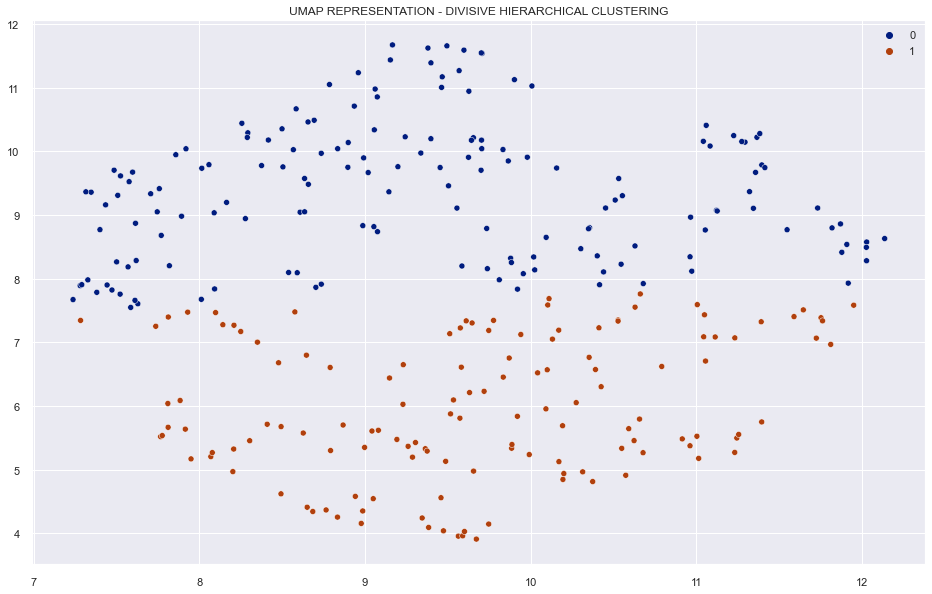

In [34]:
reducer = umap.UMAP(random_state=0)

embedding = reducer.fit_transform(df_numeric.drop("bkm_labels", axis = 1))
embedding.shape

sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=bkm.fit_predict(embedding), palette = "dark")
plt.title("UMAP REPRESENTATION - DIVISIVE HIERARCHICAL CLUSTERING");

In [35]:
metricas = [["K-means", sil_score_kme[0], ch_score_kme[0]],
            ["DBSCAN", sil_score_dbs[34], ch_score_dbs[22]],
            ["Espectral", sil_score_sc[0], ch_score_sc[0]],
            ["Divisivo", sil_score_bkm, ch_score_bkm]]

metricas_df = pd.DataFrame(metricas, columns= ["Método","Silhouette","C-H"])
metricas_df

,Método,Silhouette,C-H
0,K-means,0.179787,54.339091
1,DBSCAN,0.343571,6.958293
2,Espectral,0.157718,49.989273
3,Divisivo,0.430192,304.527779
